Name: Aayam Raj Shakya (as5160)

In [1]:
# importing requried libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# Loading wine dataset (Page 122)
df_wine = pd.read_csv('https://archive.ics.uci.edu/'
                      'ml/machine-learning-databases/wine/wine.data',
                      header=None)

df_wine.columns = ['Class label', 'Alcohol',
                   'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium',
                   'Total phenols', 'Flavanoids',
                   'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

# print('Class labels', np.unique(df_wine['Class label']))
df_wine.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [3]:
# Page 123
from sklearn.model_selection import train_test_split
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test =\
    train_test_split(X, y,
                     test_size=0.3,
                     random_state=0,
                     stratify=y)

# Page 126
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

6.1. On pp. 135-143, the sequential backward selection (SBS) is implemented as a
feature selection method and experimented with a k-NN classifier (n_neighbors=5), using the wine dataset.

In [4]:
from sklearn.base import clone
from itertools import combinations
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):

        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train,
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train,
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

a. Perform the same experiment with the k-NN classifier replaced by the support vector machine (soft-margin SVM classification).

b. In particular, analyze accuracy of the soft-margin SVM and plot the result
as in the figure on p. 139.

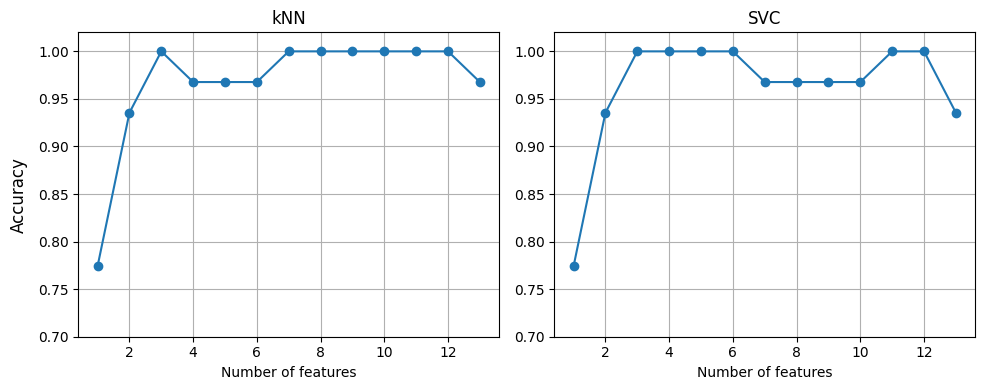

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)

sbs1 = SBS(knn, k_features=1)
sbs1.fit(X_train_std, y_train)

k_feat = [len(k) for k in sbs1.subsets_]

ax[0].plot(k_feat, sbs1.scores_, marker='o')
ax[0].set_ylim([0.7, 1.02])
ax[0].set_xlabel('Number of features')
ax[0].set_title('kNN')
ax[0].grid()

#------------------------------------------------------

from sklearn.svm import SVC

svm = SVC(kernel='rbf')

sbs2 = SBS(estimator=svm, k_features=1)
sbs2.fit(X_train_std, y_train)

s_feat = [len(k) for k in sbs2.subsets_]

ax[1].plot(s_feat, sbs2.scores_, marker='o')
ax[1].set_ylim([0.7, 1.02])
ax[1].set_xlabel('Number of features')
ax[1].set_title('SVC')
ax[1].grid()

fig.supylabel('Accuracy')
plt.tight_layout()
plt.show()

In [6]:
# Taking the indices of feature from the 7-feature subset)
print('Indices for kNN:', sbs1.subsets_[6])
print('Indices for SVM:', sbs2.subsets_[6])

Indices for kNN: (0, 1, 2, 3, 5, 7, 11)
Indices for SVM: (0, 1, 2, 3, 7, 10, 11)


In [7]:
knn_7 = list(sbs1.subsets_[6])
print('Selected classes by kNN:\n', df_wine.columns[1:][knn_7].values)
svm_7 = list(sbs2.subsets_[6])
print('\nSelected classes by SVM:\n', df_wine.columns[1:][svm_7].values)

Selected classes by kNN:
 ['Alcohol' 'Malic acid' 'Ash' 'Alcalinity of ash' 'Total phenols'
 'Nonflavanoid phenols' 'OD280/OD315 of diluted wines']

Selected classes by SVM:
 ['Alcohol' 'Malic acid' 'Ash' 'Alcalinity of ash' 'Nonflavanoid phenols'
 'Hue' 'OD280/OD315 of diluted wines']


In [8]:
# Evaluating the performance of the classifiers on the original datasets
print("kNN data:")
knn.fit(X_train_std, y_train)
print('Training accuracy:', knn.score(X_train_std, y_train))
print('Test accuracy:', knn.score(X_test_std, y_test))

print("\nSVM data:")
svm.fit(X_train_std, y_train)
print('Training accuracy:', svm.score(X_train_std, y_train))
print('Test accuracy:', svm.score(X_test_std, y_test))

kNN data:
Training accuracy: 0.967741935483871
Test accuracy: 0.9629629629629629

SVM data:
Training accuracy: 1.0
Test accuracy: 1.0


When we train both kNN and SVM classifiers with the whole dataset, we get to see that SVM is superior to kNN.

In [9]:
# Evaluating the performance of the classifiers on our 7-feature subset
print("kNN data:")
knn.fit(X_train_std[:,knn_7], y_train)
print('Training accuracy:', knn.score(X_train_std[:,knn_7], y_train))
print('Test accuracy:', knn.score(X_test_std[:,knn_7], y_test))

print("\nSVM data:")
svm.fit(X_train_std[:,svm_7], y_train)
print('Training accuracy:', svm.score(X_train_std[:,svm_7], y_train))
print('Test accuracy:', svm.score(X_test_std[:,svm_7], y_test))


kNN data:
Training accuracy: 0.9435483870967742
Test accuracy: 0.9259259259259259

SVM data:
Training accuracy: 0.9919354838709677
Test accuracy: 0.9814814814814815


When we train both classifiers with just 7/13 features, the SVM classifier still performs better than kNN.

## Extra (from geeksofgeeks)
https://www.geeksforgeeks.org/optimal-feature-selection-for-support-vector-machines/

In [10]:
from sklearn.svm import SVC
from sklearn.feature_selection import SequentialFeatureSelector

# Initialize SVM classifier
svm = SVC(kernel='rbf')

# Backward Feature Selection
sfs = SequentialFeatureSelector(estimator=svm,
                                n_features_to_select=4,
                                direction='backward')
sfs.fit(X_train_std, y_train)

# Selected feature indices
selected_features = sfs.get_support(indices=True)

# Use selected features for training and testing
X_train_selected = X_train_std[:, selected_features]
X_test_selected = X_test_std[:, selected_features]

# Train SVM model with selected features
svm_selected = SVC(kernel='rbf')
svm_selected.fit(X_train_selected, y_train)

# Evaluate model performance
accuracy = svm_selected.score(X_test_selected, y_test)
print("Accuracy with selected features:", accuracy)

Accuracy with selected features: 0.9814814814814815


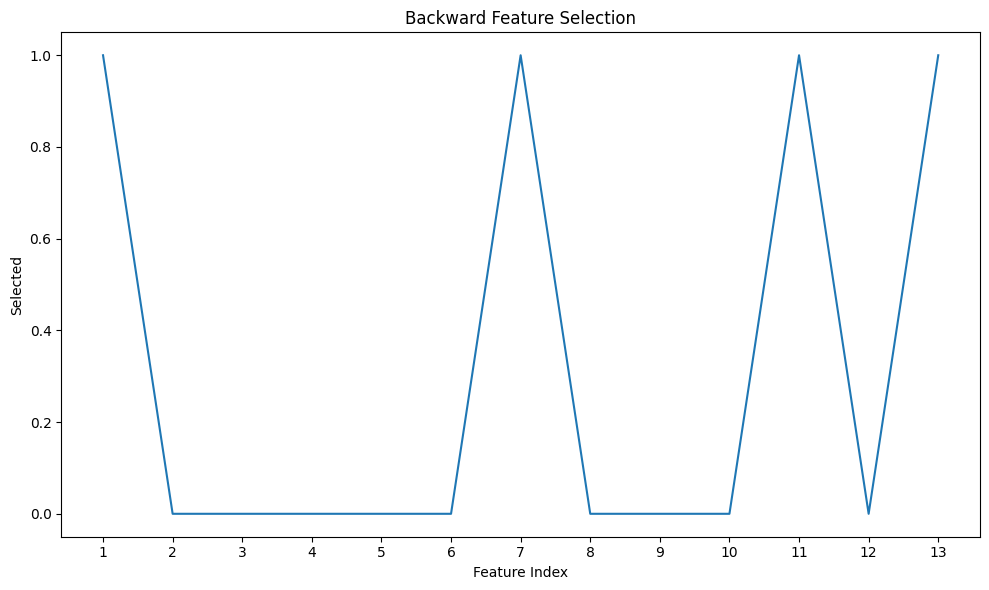

In [11]:
# Visualize the selected features
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(sfs.support_) + 1), sfs.support_)
plt.xticks(range(1, len(sfs.support_) + 1))  # Added to show full x-axis
plt.xlabel('Feature Index')
plt.ylabel('Selected')
plt.title('Backward Feature Selection')
plt.tight_layout()
plt.show()

The features with selected value of 1.0 are those that are optimal and hence selected for training.

From the plot above, indices 1, 7, 11, and 13 or Alcohol, Flavanoids, Hue, and Proline classes, respectively, make the most impact together when we have to choose just 4 features (n_features_to_select=4).

6.2. On pp. 141-143, the permutation feature importance is assessed from the random forest classifier, using the wine dataset.

a. Discuss whether or not you can derive feature importance for a k-NN classifier.

Answer: The kNN classifier is a dumb algorithm. It doesn't perform high-level calculation behind the scene or compute the correlation between the data points (x-labels) and features (y-labels), and relies solely on the proximity of the data points.

There's one tweak to estimate feature importance using kNN though. We can take the sample to predict on, compute its distance from each of its nearest neighbors for each feature (call these `neighbor_dist`). Then, do the same computations for a few random points (call these `random_dist`) instead of the nearest neighbors. Then, for each feature, we take the ratio of `neighbor_dist / random_dist`, and the smaller the ratio, the more important that feature is.

REFERENCE: https://stackoverflow.com/a/55315400

Owing to this level of complexity, the kNN classifier algorithm isn't an ideal choice to derive feature importance.


b. Assess feature importance with the logistic regression classifier, using the
same dataset.

  Index  Labels                          Random forest    Logistic regression
-------  ----------------------------  ---------------  ---------------------
      1  Proline                             0.185453                1.01526
      2  Flavanoids                          0.174751                4.10606
      3  Color intensity                     0.14392                 0.948634
      4  OD280/OD315 of diluted wines        0.136162                1.6014
      5  Alcohol                             0.118529                0.509164
      6  Hue                                 0.058739                0.943038
      7  Total phenols                       0.0508724               1.10934
      8  Magnesium                           0.0313571               1.00439
      9  Malic acid                          0.0256484               2.03447
     10  Proanthocyanins                     0.0255699               0.609442
     11  Alcalinity of ash                   0.0223659               0.

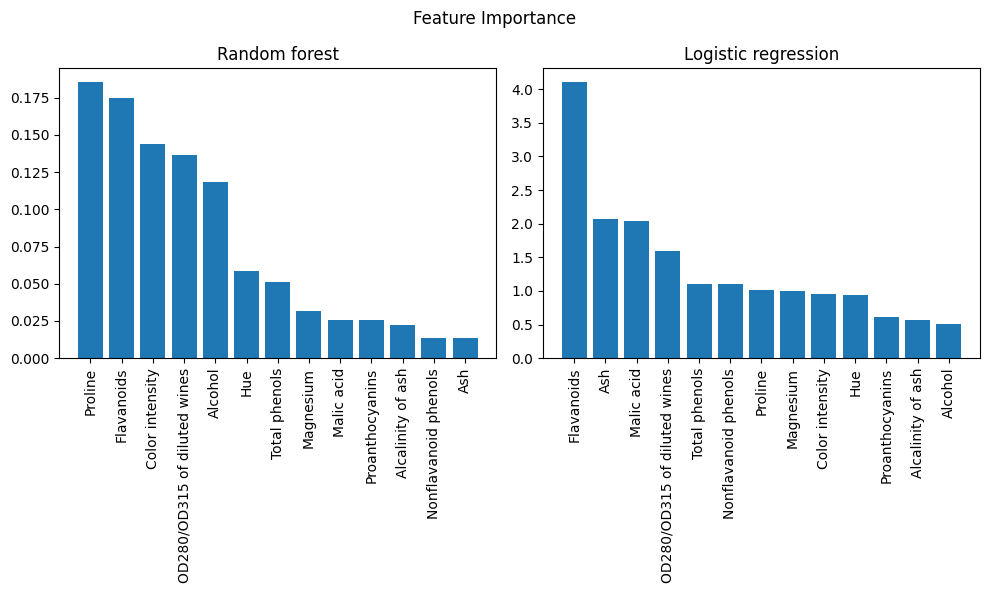


Accuracy when trained on all 13 features

Random forest accuracy: 1.0000 and Logistic regression accuracy: 0.9444


In [12]:
# REFERENCE: https://www.geeksforgeeks.org/understanding-feature-importance-in-logistic-regression-models/
from tabulate import tabulate
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

feat_labels = df_wine.columns[1:]

forest = RandomForestClassifier(n_estimators=500, random_state=1)
logit = LogisticRegression(max_iter=10000, solver='liblinear')
# liblinear solver supports both L1 and L2 regularization and
# is a good choice for small datasets

forest.fit(X_train, y_train)
logit.fit(X_train, y_train)
forest_importances = forest.feature_importances_
logit_importances = np.exp(logit.coef_[0])
# odd ratio = np.exp(coefficients)
# I exponentiated the coefficients because some 'importance' values were
# negative, which distorted the plot.
# This doesn't affect the order of importance though.

indices = np.argsort(forest_importances)[::-1]
logit_indices = np.argsort(logit_importances)[::-1]

table = []
for f in range(X_train.shape[1]):
  each_row = [f+1, feat_labels[indices[f]],
              forest_importances[indices[f]],
              logit_importances[indices[f]]]
  table.append(each_row)

headers = ["Index", "Labels", "Random forest", "Logistic regression"]
print(tabulate(table, headers=headers))
print('\n')

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))

# Plotting data
ax[0].set_title('Random forest')
ax[0].bar(range(X_train.shape[1]),
        forest_importances[indices],
        align='center')

ax[0].set_xticks(range(X_train.shape[1]),
           feat_labels[indices], rotation=90)
ax[0].set_xlim([-1, X_train.shape[1]])

#-----------------------------------------------------

ax[1].set_title('Logistic regression')
ax[1].bar(range(X_train.shape[1]),
        logit_importances[logit_indices],
        align='center')

ax[1].set_xticks(range(X_train.shape[1]),
           feat_labels[logit_indices], rotation=90)
ax[1].set_xlim([-1, X_train.shape[1]])

plt.suptitle("Feature Importance")
plt.tight_layout()
plt.show()


# Calculate accuracy
forest_pred = forest.predict(X_test)
forest_accuracy = accuracy_score(y_test, forest_pred)

logit_pred = logit.predict(X_test)
logit_accuracy = accuracy_score(y_test, logit_pred)

print("\nAccuracy when trained on all 13 features")
print(f"\nRandom forest accuracy: {forest_accuracy:.4f}\
 and Logistic regression accuracy: {logit_accuracy:.4f}")

Based on the plots, the logistic regression classifier gave different results for the same input, which is expected.

Random forest is better than logistic regression because:

1. Logistic regression assumes linear relationships between the variables, whereas random forest can handle non-linear relationships. Our wine dataset isn't linear entirely.
2. Random forest makes predictions based on an ensemble of decision trees, combining multiple weaker models to get a better final result.

REFERENCE: https://www.geeksforgeeks.org/logistic-regression-vs-random-forest-classifier/

We can achieve better performance for logistic regression by tweaking the model with different parameters.

c. Based on the computed feature importance, analyze and plot accuracy of the
logistic regression classifier for k_features = 1, 2, · · · , 13.

In [13]:
logit_indices = np.argsort(logit_importances)[::-1]
logit_indices

array([ 6,  2,  1, 11,  5,  7, 12,  4,  9, 10,  8,  3,  0])

In [14]:
accuracy_ = []

# Iteratively eval the model from 1 to k-th feature importance
for i in range(1, X_train.shape[1]+1):
  feature_amt = logit_indices[:i]
  logit = LogisticRegression(max_iter=10000, solver='liblinear')
  logit.fit(X_train[:, feature_amt], y_train)
  logit_pred = logit.predict(X_test[:, feature_amt])
  accuracy_.append(round(accuracy_score(y_test, logit_pred),2))

print (accuracy_)

[0.81, 0.81, 0.83, 0.76, 0.74, 0.74, 0.87, 0.89, 0.91, 0.91, 0.93, 0.98, 0.94]


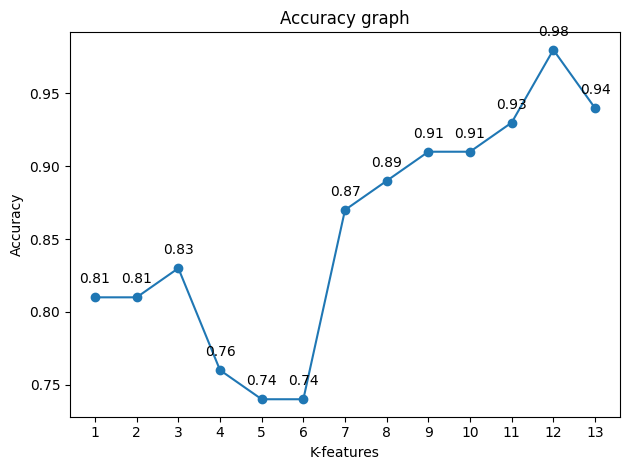

In [15]:
# REFERENCE: https://queirozf.com/entries/add-labels-and-text-to-matplotlib-plots-annotation-examples
x_axis = range(1, len(accuracy_) + 1); y_axis = accuracy_
plt.plot(x_axis, y_axis, marker='o')
plt.xticks(range(1, len(accuracy_) + 1))
plt.ylabel('Accuracy')
plt.xlabel('K-features')
plt.title('Accuracy graph')

for x,y in zip(x_axis, y_axis):
  label = "{}".format(y)
  plt.annotate(label,
               (x,y),
               textcoords="offset points",
               xytext=(0, 10),
               ha='center')

plt.tight_layout()
plt.show()

Based on the graph, our logistic regression classifier achieves an accuracy of 81% when we use only the 1st important feature. As we introduce more features at around 5th and 6th, the accuracy dips below 75%. From `k=7` onward, the accuracy improves and reaches its peak at `k=12`. This shows that selecting the 12 most important features gives us the best model accuracy.